In [1]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
from tqdm import tqdm
from itertools import product
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torchsummary import summary
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models

from sklearn.model_selection import train_test_split
from scipy.optimize import nnls
from collections import Counter

# Check for GPU availability
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Reproducibility
Achieving reproducible results is a cornerstone of scientific research. 

In the context of Deep Learning, this means ensuring that a model will produce the same results on the same data, regardless of when or where it is run. This is challenging due to the inherent randomness in model initialization and data shuffling. 
To avoid (or minimize) it, we fix the random seed across all libraries that generate random numbers.

In [2]:
def set_seed(seed=7):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)

    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Numpy RNG
    np.random.seed(seed)

    # OS RNG
    os.environ["PYTHONHASHSEED"] = str(seed)


def worker_init_fn(worker_id):
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)


set_seed(7)

### Hyperparameters

In [3]:
# Hyperparameters
batch_size = 30
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 20
learning_rate = 0.01

### Data Preparation

In [4]:
# Import the csv from path.
label_path = "data\pizza_data\imageLabels.txt"
column_path = "data\pizza_data\categories.txt"
image_path = "data\pizza_data\images"

df = pd.read_csv(label_path, sep="  ", header=None)
df.columns = open(column_path, "r").read().split("\n")[:-1]
classes = len(open(column_path, "r").read().split("\n")[:-1]) + 1
open(column_path, "r").close()


# Encode a label of pizzas without labeled toppings.
df["Other"] = 0
df["image_name"] = df.apply(
    lambda x: os.path.join(image_path, str(x.name + 1).zfill(5) + ".jpg"), axis=1
)
df.loc[df.iloc[:, :-1].max(axis=1) == 0, "Other"] = 1

C:\Users\20202016\AppData\Local\Temp\ipykernel_17880\437031362.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(label_path, sep="  ", header=None)


After attempting to create a binary classification, the difficulty should be improved to create a multiclass-task.
For now, let's create a model that can determine between three classes.
Since one image can contain multiple toppings, we want to avoid using the same image multiple times.

In [5]:
from collections import Counter
import itertools

# Create a list of all possible topping combinations
all_toppings = df.columns[:-1]
topping_combinations = [
    ",".join(combo)
    for i in range(1, len(all_toppings) + 1)
    for combo in itertools.combinations(all_toppings, i)
]

# Count the frequency of each topping combination
combo_counts = Counter()
for row in df.itertuples(index=False):
    toppings = [t for t, v in zip(all_toppings, row) if v == 1]
    combo_counts[",".join(toppings)] += 1

# Sort the combinations by frequency and print the top 10
top_combos = combo_counts.most_common(10)
print("Top 10 Topping Combinations:")
for combo, count in top_combos:
    print(f"{combo}: {count}")

Top 10 Topping Combinations:
Other: 2767
Pepperoni: 1309
Fresh basil: 751
Tomatoes: 587
Mushrooms: 304
Onions: 220
Tomatoes,Fresh basil: 219
Black olives: 211
Spinach: 190
Peppers: 145


Let's first train a model that can overfit with imbalanced classes with a small image size.

In [6]:
# Create the dataset based on three most occuring classes
labels = ["Other", "Pepperoni", "Fresh basil"]
df = df[labels]
df["image_name"] = df.apply(
    lambda x: os.path.join(image_path, str(x.name + 1).zfill(5) + ".jpg"), axis=1
)

# Filter the dataset to include only rows with exactly one '1' in the labels
filtered_df = df[df.drop("image_name", axis=1).sum(axis=1) == 1]

# Reset the index of the filtered DataFrame
filtered_df = filtered_df.reset_index(drop=True)

# Calculate the distribution of class labels
class_distribution = filtered_df[labels].sum() / len(filtered_df)

# Create a weight vector for each row based on the class distribution
weights = np.zeros(len(filtered_df))
for i, row in filtered_df.iterrows():
    label = row[labels].idxmax()
    weights[i] = class_distribution[label]

# Sample from the filtered dataset based on the distribution of class labels
sample_size = 500
sampled_df = filtered_df.sample(n=sample_size, replace=True, weights=weights)

# Split the data in training and validation.
train_df, test_df = train_test_split(
    sampled_df, train_size=0.8, shuffle=True, random_state=7
)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iat[idx, -1]  # the path is in the last column
        image = Image.open(image_name).convert("RGB")

        # Get the true labels
        true_labels = (
            self.dataframe.drop("image_name", axis=1).iloc[idx].values.astype("float32")
        )

        # Convert the labels to a single integer representing the true class index
        true_label = torch.argmax(torch.tensor(true_labels))

        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, true_label

In [8]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 400 - Reduced train set size: 5000 - Test set size: 100


Let's normalize the input data, to improve the learning process, by using Standard Normalization.
we first need to calculate the mean and variance of the pixel values across the entire training dataset. These statistics are then used to normalize both the training and validation/test datasets. 

In [9]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for iteration in tqdm(iter(loader)):
        images = iteration[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0)
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images

    return mean, variance


# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:07<00:00,  1.87it/s]

Mean: tensor([0.6237, 0.4727, 0.3620])
Standard Deviation: tensor([0.2186, 0.2232, 0.2215])


Furthermore, we need to add the input normalization.

In [10]:
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 400 - Reduced train set size: 5000 - Test set size: 100


## Input visualization

Let's visualize a set of images from the dataset.

Label: Fresh Basil


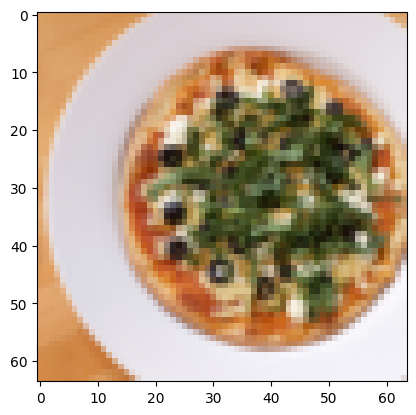

Label: Pepperoni


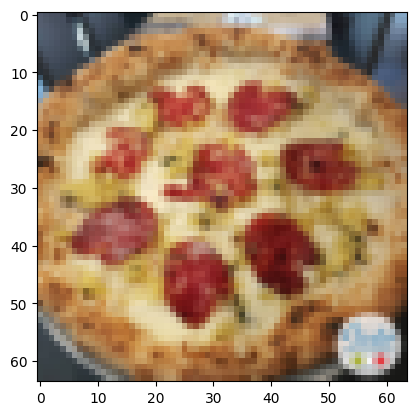

Label: Other


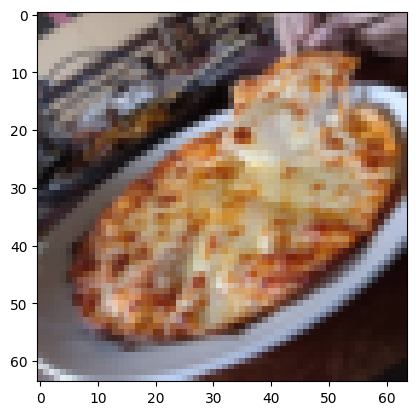

Label: Pepperoni


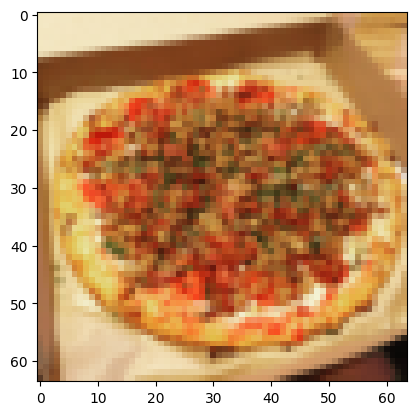

Label: Pepperoni


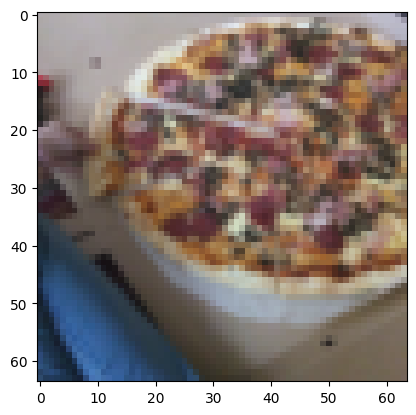

In [11]:
num_images = 5


def denormalize(img, mean, std):
    """Denormalizes an image to its original form using mean and std"""
    mean = (
        torch.tensor(mean).reshape(-1, 1, 1)
        if not isinstance(mean, torch.Tensor)
        else mean.reshape(-1, 1, 1)
    )
    std = (
        torch.tensor(std).reshape(-1, 1, 1)
        if not isinstance(std, torch.Tensor)
        else std.reshape(-1, 1, 1)
    )
    denorm_img = img * std + mean  # Apply denormalization
    return denorm_img


def imshow(img, mean, std):
    """Shows an image by first denormalizing it"""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 255)  # Ensure the image is within [0, 255]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Select random images and plot them with labels
classes = ["Other", "Pepperoni", "Fresh Basil"]

# Display the images with denormalization
for i in random.sample(range(len(test_dataset)), num_images):
    image, label = (
        test_dataset[i][0],
        test_dataset[i][1],
    )  # Ensure that you're accessing the tensor image
    print("Label:", classes[label])
    imshow(image, mean, std)  # Pass mean and std as tensors

## Basic Neural Network Architecture

In [12]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(len(classes)).to(device)
summary(linear_model, (3, 64, 64), device=device)
print("Device is " + device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─ReLU: 2-2                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 21, 21]          --
|    └─Conv2d: 2-4                       [-1, 96, 21, 21]          55,392
|    └─ReLU: 2-5                         [-1, 96, 21, 21]          --
|    └─MaxPool2d: 2-6                    [-1, 96, 7, 7]            --
|    └─Conv2d: 2-7                       [-1, 128, 7, 7]           110,720
|    └─ReLU: 2-8                         [-1, 128, 7, 7]           --
|    └─MaxPool2d: 2-9                    [-1, 128, 2, 2]           --
|    └─Flatten: 2-10                     [-1, 512]                 --
|    └─Linear: 2-11                      [-1, 3]                   1,539
Total params: 169,443
Trainable params: 169,443
Non-trainable params: 

## Loss function and optimizer

When choosing a loss function and an optimizer for a neural network, it's important to consider the specific task at hand. 

For classification tasks, Cross Entropy Loss and optimizers like SGD or Adam are common choices. 

In [13]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

## Training

In [14]:
def train_and_validate(
    model, train_loader, test_loader, criterion, optimizer, epochs, device
):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss /= len(test_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(
            f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%"
        )

    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


def plot_metrics(
    train_losses, train_accuracies, validation_losses, validation_accuracies
):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(validation_accuracies, label="Validation Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/10], Training Loss: 1.0180, Training Accuracy: 52.75%, Validation Loss: 0.9937, Validation Accuracy: 50.00%
Epoch [2/10], Training Loss: 0.9438, Training Accuracy: 54.50%, Validation Loss: 0.9974, Validation Accuracy: 53.00%
Epoch [3/10], Training Loss: 0.8955, Training Accuracy: 59.25%, Validation Loss: 0.9931, Validation Accuracy: 53.00%
Epoch [4/10], Training Loss: 0.8389, Training Accuracy: 62.50%, Validation Loss: 0.9580, Validation Accuracy: 51.00%
Epoch [5/10], Training Loss: 0.7687, Training Accuracy: 67.50%, Validation Loss: 0.9531, Validation Accuracy: 54.00%
Epoch [6/10], Training Loss: 0.7045, Training Accuracy: 71.25%, Validation Loss: 0.9232, Validation Accuracy: 57.00%
Epoch [7/10], Training Loss: 0.6401, Training Accuracy: 73.00%, Validation Loss: 0.9000, Validation Accuracy: 61.00%
Epoch [8/10], Training Loss: 0.5549, Training Accuracy: 78.25%, Validation Loss: 0.9248, Validation Accuracy: 62.00%
Epoch [9/10], Training Loss: 0.4581, Training Accuracy: 83.75%, 

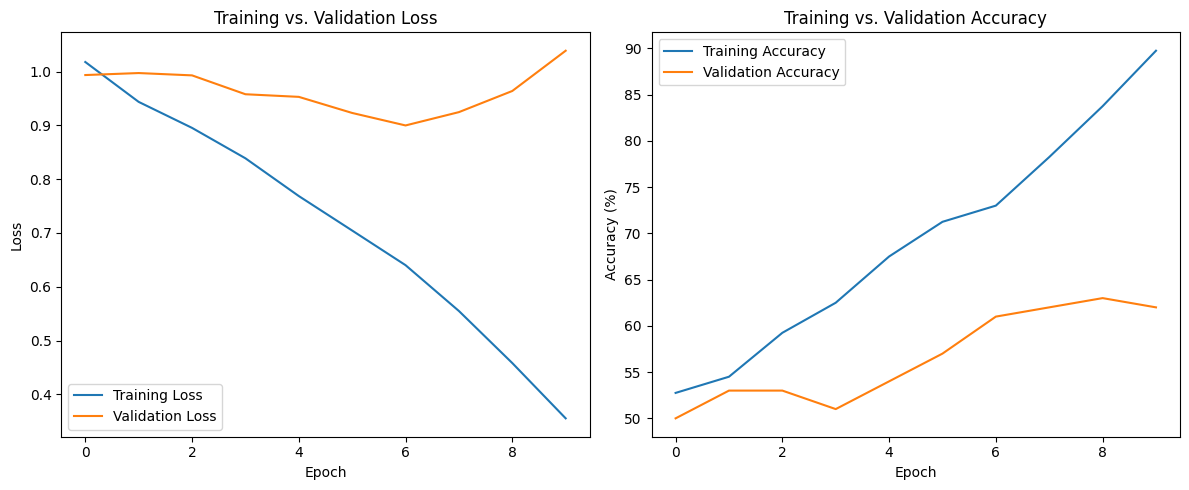

In [15]:
train_losses, train_accuracies, validation_losses, validation_accuracies = (
    train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, 10, device
    )
)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

The model clearly overfits on the majority training. This is can be fixed with regularization.

### Pairwise - Interactions

Let's finalize the multi-class evaluation through by pairing the labels based on an interaction. There are two options:
combininig those labels with a similar color or combining labels based on their co-occurence. Since from the data it can be seen that most labels co-occur a lot with tomatoes, we will opt for pairwise-relation in terms of color.

In [16]:
df = pd.read_csv(label_path, sep="  ", header=None)
df.columns = open(column_path, "r").read().split("\n")[:-1]
classes = len(open(column_path, "r").read().split("\n")[:-1]) + 1
open(column_path, "r").close()


color_dct = {
    "Red": ["Pepperoni", "Tomatoes"],
    "Brown": ["Bacon", "Mushrooms", "Black olives"],
    "Multi": ["Peppers"],
    "Green": ["Spinach", "Fresh basil", "Arugula", "Broccoli"],
    "Yellow": ["Corn", "Pineapple"],
    "Purple": ["Onions"],
}

C:\Users\20202016\AppData\Local\Temp\ipykernel_17880\3982993643.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(label_path, sep="  ", header=None)


Group the labels based on their color.

In [17]:
# Create a new dataframe with grouped columns based on color dictionary
color_df = pd.DataFrame()

for color, toppings in color_dct.items():
    color_df[f"{color}"] = df[toppings].any(axis=1).astype(int)


color_df["image_name"] = df.apply(
    lambda x: os.path.join(image_path, str(x.name + 1).zfill(5) + ".jpg"), axis=1
)

color_df = color_df.apply(
    lambda x: (
        x
        if sum(x.drop("image_name")) <= 1
        else pd.concat(
            [
                (
                    pd.Series(
                        {
                            "Red": 0,
                            "Brown": 0,
                            "Multi": 1,
                            "Green": 0,
                            "Yellow": 0,
                            "Purple": 0,
                        },
                        name=x.name,
                    )
                ),
                pd.Series({"image_name": x.image_name}),
            ]
        )
    ),
    axis=1,
)

color_df["Plain"] = 0
color_df.loc[color_df.drop(columns="image_name").max(axis=1) == 0, "plain"] = 1
color_df = color_df[
    ["Plain", "Multi", "Red", "Brown", "Green", "Yellow", "Purple", "image_name"]
]
color_df.describe()

,Plain,Multi,Red,Brown,Green,Yellow,Purple
count,9213.0,9213.000000,9213.000000,9213.000000,9213.000000,9213.000000,9213.000000
mean,0.0,0.266146,0.216216,0.068599,0.114078,0.010746,0.023879
std,0.0,0.441965,0.411686,0.252784,0.317923,0.103109,0.152681
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
color_df

,Plain,Multi,Red,Brown,Green,Yellow,Purple,image_name
0,0,1,0,0,0,0,0,data\pizza_data\images\00001.jpg
1,0,0,0,0,1,0,0,data\pizza_data\images\00002.jpg
2,0,0,0,0,1,0,0,data\pizza_data\images\00003.jpg
3,0,1,0,0,0,0,0,data\pizza_data\images\00004.jpg
4,0,1,0,0,0,0,0,data\pizza_data\images\00005.jpg
...,...,...,...,...,...,...,...,...
9208,0,0,0,0,0,0,0,data\pizza_data\images\09209.jpg
9209,0,0,0,1,0,0,0,data\pizza_data\images\09210.jpg
9210,0,0,0,0,0,0,0,data\pizza_data\images\09211.jpg
9211,0,0,0,0,0,0,0,data\pizza_data\images\09212.jpg


In [19]:
# Sample from the color dataset based on the distribution of class labels
sample_size = 500
sampled_df = color_df.sample(n=sample_size, replace=True, weights=None)

# Split the data in training and validation.
train_df, test_df = train_test_split(
    sampled_df, train_size=0.8, shuffle=True, random_state=7
)

# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 400 - Reduced train set size: 5000 - Test set size: 100


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:08<00:00,  1.69it/s]

Mean: tensor([0.6138, 0.4676, 0.3528])
Standard Deviation: tensor([0.2184, 0.2213, 0.2188])
Full train set size: 400 - Test set size: 100


Label: Red


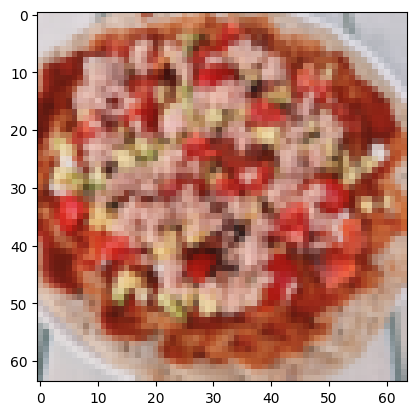

Label: Multi


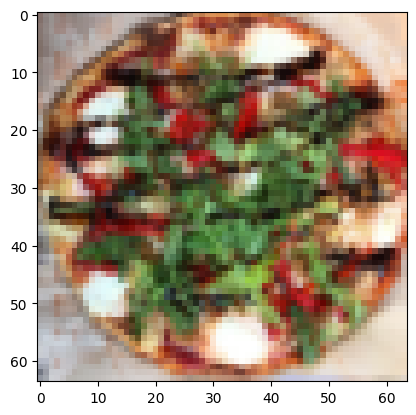

Label: Red


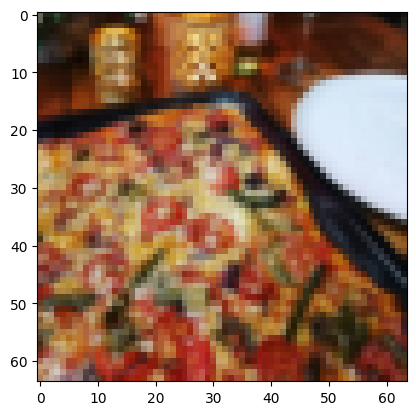

Label: Green


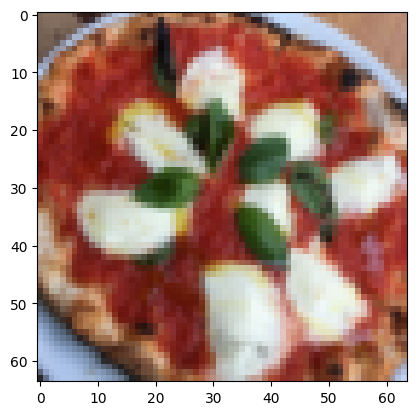

Label: Red


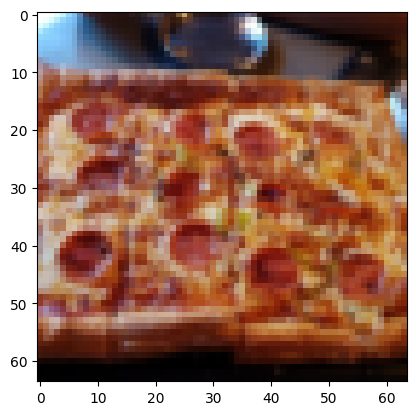

In [20]:
# Select random images and plot them with labels
classes = ["Plain", "Multi", "Red", "Brown", "Green", "Yellow", "Purple"]

# Display the images with denormalization
for i in random.sample(range(len(test_dataset)), num_images):
    image, label = (
        test_dataset[i][0],
        test_dataset[i][1],
    )  # Ensure that you're accessing the tensor image
    print("Label:", classes[label])
    imshow(image, mean, std)  # Pass mean and std as tensors

In [21]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(len(classes)).to(device)
summary(linear_model, (3, 64, 64), device=device)
print("Device is " + device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 7]                   --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─ReLU: 2-2                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 21, 21]          --
|    └─Conv2d: 2-4                       [-1, 96, 21, 21]          55,392
|    └─ReLU: 2-5                         [-1, 96, 21, 21]          --
|    └─MaxPool2d: 2-6                    [-1, 96, 7, 7]            --
|    └─Conv2d: 2-7                       [-1, 128, 7, 7]           110,720
|    └─ReLU: 2-8                         [-1, 128, 7, 7]           --
|    └─MaxPool2d: 2-9                    [-1, 128, 2, 2]           --
|    └─Flatten: 2-10                     [-1, 512]                 --
|    └─Linear: 2-11                      [-1, 7]                   3,591
Total params: 171,495
Trainable params: 171,495
Non-trainable params: 

In [22]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

Epoch [1/10], Training Loss: 1.7182, Training Accuracy: 27.00%, Validation Loss: 1.5988, Validation Accuracy: 27.00%
Epoch [2/10], Training Loss: 1.6181, Training Accuracy: 27.75%, Validation Loss: 1.4869, Validation Accuracy: 33.00%
Epoch [3/10], Training Loss: 1.5608, Training Accuracy: 36.50%, Validation Loss: 1.4342, Validation Accuracy: 41.00%
Epoch [4/10], Training Loss: 1.4950, Training Accuracy: 41.25%, Validation Loss: 1.4272, Validation Accuracy: 40.00%
Epoch [5/10], Training Loss: 1.4598, Training Accuracy: 42.50%, Validation Loss: 1.4306, Validation Accuracy: 42.00%
Epoch [6/10], Training Loss: 1.4161, Training Accuracy: 44.00%, Validation Loss: 1.4322, Validation Accuracy: 45.00%
Epoch [7/10], Training Loss: 1.3449, Training Accuracy: 47.50%, Validation Loss: 1.4569, Validation Accuracy: 45.00%
Epoch [8/10], Training Loss: 1.2591, Training Accuracy: 52.00%, Validation Loss: 1.5009, Validation Accuracy: 44.00%
Epoch [9/10], Training Loss: 1.1741, Training Accuracy: 55.50%, 

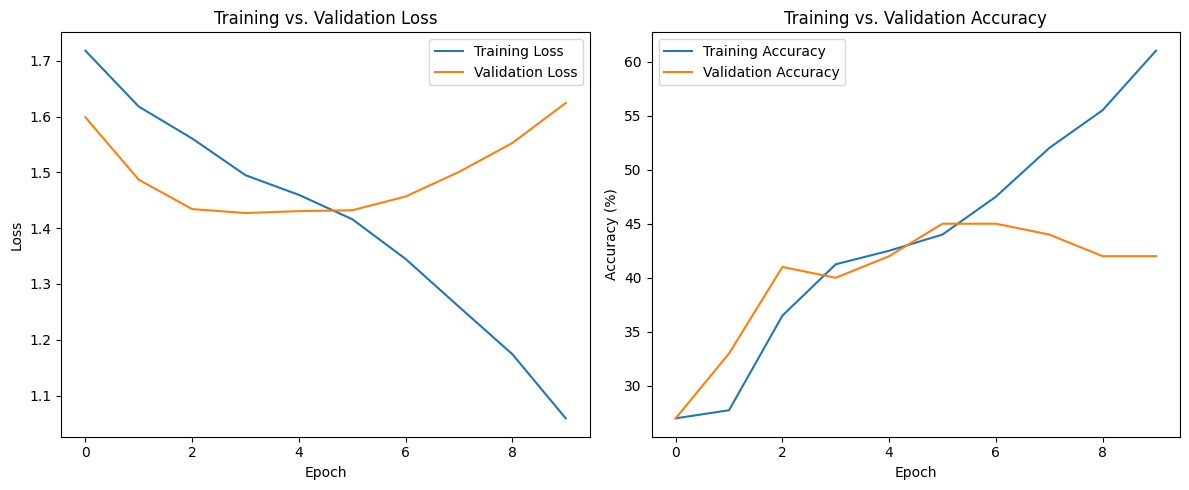

In [23]:
train_losses, train_accuracies, validation_losses, validation_accuracies = (
    train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, 10, device
    )
)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

The model suffers from the class imbalance, since it overfits on the majority class. Let's try to fix this.

In [24]:
def balance(df, number_aim=1000, equal_output=True, print_most_common=True):
    df["Plain"] = 0
    df.loc[df.drop(columns="image_name").max(axis=1) == 0, "Plain"] = 1

    # Calculate the count of occurrences of each label

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    df.drop(columns="image_name").sum().plot(kind="bar")
    plt.title("Current distribution of Pizza Toppings")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    balance_df = df.drop(columns="image_name")
    lst = []
    for label in balance_df.columns:
        res_lst = (
            balance_df[balance_df[label] == 1].sum()
            / balance_df[balance_df[label] == 1].sum().max()
        )
        lst.append([round(value, 2) for value in res_lst.tolist()])

    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(lst, annot=True)
    ax.tick_params(axis="y", labelrotation=0)
    ax.set_xticklabels(balance_df.columns)
    ax.set_yticklabels(balance_df.columns)
    plt.show()

    mults = nnls(np.array(lst).T, np.repeat(number_aim, len(lst)))
    mults_df = pd.DataFrame(mults[0].round(), index=balance_df.columns)

    indices = []
    for label in balance_df.columns:
        indices += (
            int(mults_df.loc[label, 0] // len(balance_df[balance_df[label] == 1].index))
            * balance_df[balance_df[label] == 1].index.tolist()
        )
        indices += random.sample(
            balance_df[balance_df[label] == 1].index.tolist(),
            int(mults_df.loc[label, 0] % len(balance_df[balance_df[label] == 1].index)),
        )

    if not equal_output:
        # Plotting the distribution
        plt.figure(figsize=(10, 6))
        balance_df.loc[indices].sum().plot(kind="bar")
        plt.title("Distribution of Pizza Toppings")
        plt.xlabel("Labels")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        if print_most_common:
            print(Counter(indices).most_common())

        return df.loc[indices]

    else:
        distribution = balance_df.loc[indices].sum().to_numpy()
        non_used_df = balance_df.loc[
            random.sample(
                list(set(balance_df.index).difference(set(indices))),
                len(balance_df) - len(np.unique(indices)),
            )
        ]
        max_height = distribution.max()
        for index in non_used_df.index:
            # First try to fill the lower observations with pizzas from the train set which are not already used
            if all((distribution + non_used_df.loc[index].to_numpy()) <= max_height):
                indices.append(index)
                distribution += non_used_df.loc[index].to_numpy()

        while any(distribution != max_height):
            # Then fill with dupes from the entire dataframe
            ingredient = random.sample(
                balance_df.columns[distribution != max_height].to_list(), 1
            )[0]
            if all(
                (
                    distribution
                    + balance_df[balance_df[ingredient] == 1].to_numpy().sum(axis=0)
                )
                <= max_height
            ):
                indices += balance_df[balance_df[ingredient] == 1].index.to_list()
                distribution += (
                    balance_df[balance_df[ingredient] == 1].to_numpy().sum(axis=0)
                )

            else:
                index = random.sample(
                    balance_df[balance_df[ingredient] == 1].index.to_list(), 1
                )[0]

                while any(
                    (distribution + balance_df.loc[index].to_numpy()) > max_height
                ):
                    index = random.sample(
                        balance_df[balance_df[ingredient] == 1].index.to_list(), 1
                    )[0]

                indices.append(index)
                distribution += balance_df.loc[index].to_numpy()

        plt.figure(figsize=(10, 6))
        pd.DataFrame(distribution).plot(kind="bar")
        plt.title("Distribution of Pizza Toppings")
        plt.xlabel("Labels")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        if print_most_common:
            print(Counter(indices).most_common())

        return df.loc[indices]

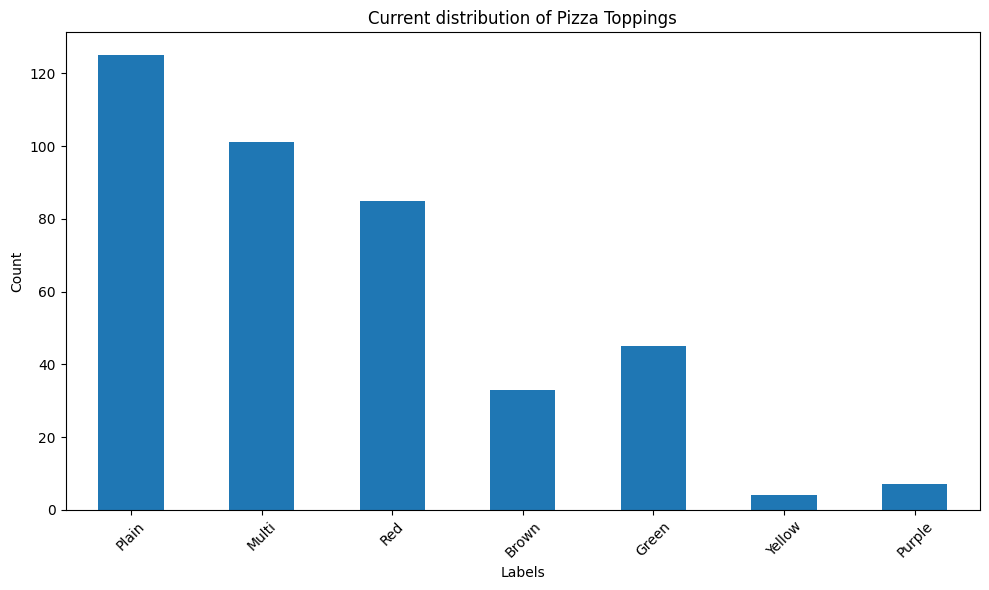

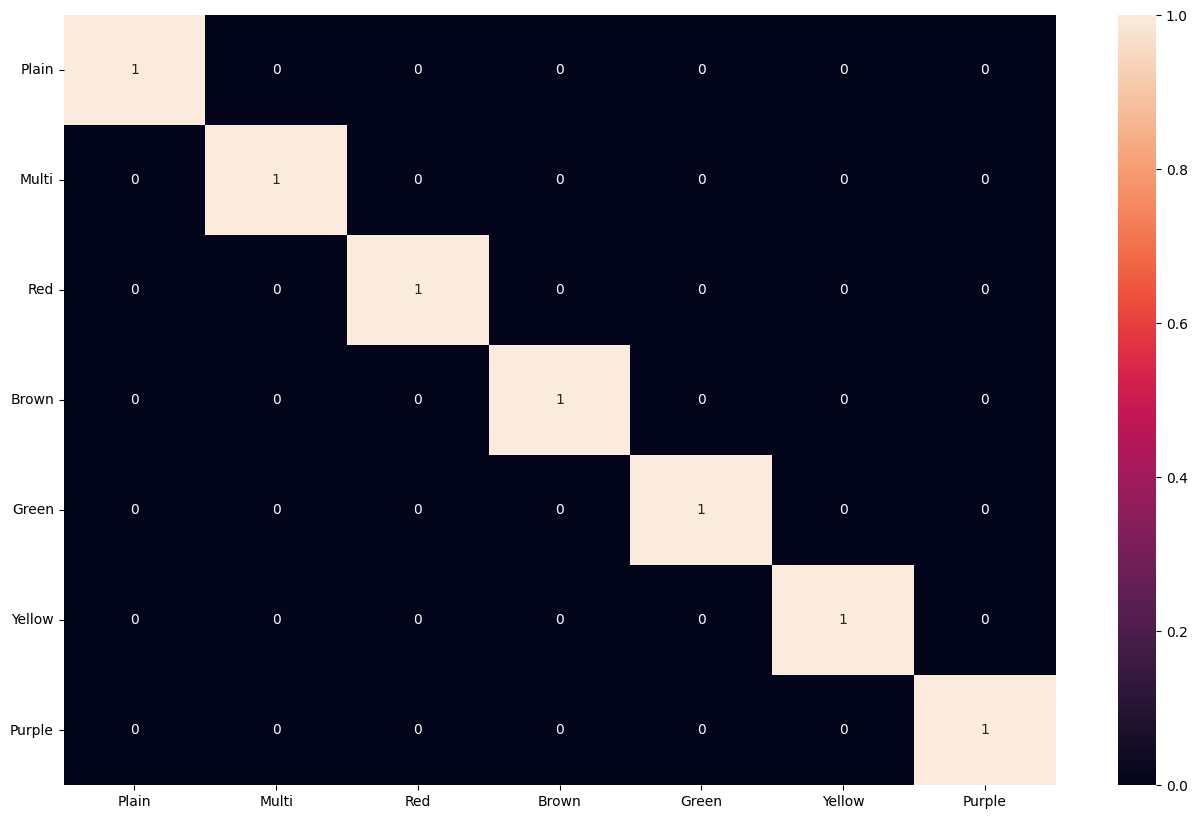

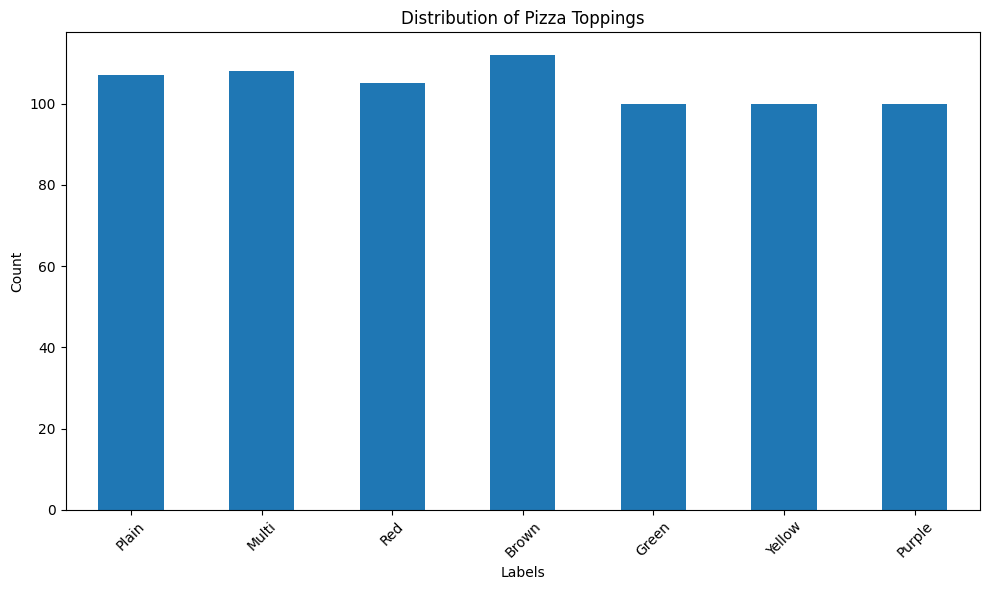

[(8314, 25), (5455, 25), (4713, 25), (7253, 25), (4495, 15), (4873, 15), (2390, 14), (7712, 14), (7860, 14), (534, 14), (2723, 14), (781, 6), (5458, 6), (2876, 4), (5642, 3), (2430, 3), (1750, 3), (1672, 3), (7304, 3), (1239, 3), (7433, 3), (2890, 3), (7832, 3), (153, 3), (1972, 3), (5700, 3), (1624, 3), (8735, 3), (4997, 3), (815, 3), (2760, 3), (5442, 3), (686, 3), (4069, 3), (4792, 3), (5545, 3), (6388, 3), (1630, 3), (1912, 3), (3011, 3), (50, 3), (1563, 3), (211, 3), (3000, 3), (4775, 3), (888, 3), (1880, 3), (1571, 3), (6197, 3), (4162, 3), (1043, 3), (812, 3), (1575, 3), (4229, 2), (1967, 2), (7741, 2), (2617, 2), (5278, 2), (3994, 2), (4176, 2), (3078, 2), (4255, 2), (3833, 2), (5457, 2), (3751, 2), (1973, 2), (7310, 2), (8983, 2), (2353, 2), (5515, 2), (2210, 2), (8020, 2), (4590, 2), (478, 2), (8182, 2), (2243, 2), (8752, 2), (3884, 2), (5113, 2), (4751, 2), (5123, 2), (1319, 2), (7829, 2), (1186, 2), (2884, 2), (1904, 2), (1867, 2), (5520, 2), (1316, 2), (1663, 2), (319, 2),

In [25]:
balanced_df = balance(train_df, equal_output=False, number_aim=100)

In [26]:
# # Split the data in training and validation.
# train_df, test_df = train_test_split(
#     balanced_df[balanced_df.columns[:-1]], train_size=0.8, shuffle=True, random_state=7
# )

# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=balanced_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
# This time do not forget to shuffle
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=balanced_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 732 - Reduced train set size: 5000 - Test set size: 100


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:13<00:00,  1.88it/s]

Mean: tensor([0.6088, 0.4647, 0.3399])
Standard Deviation: tensor([0.2183, 0.2179, 0.2128])
Full train set size: 732 - Test set size: 100


In [27]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(len(classes)).to(device)
summary(linear_model, (3, 64, 64), device=device)
print("Device is " + device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 7]                   --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─ReLU: 2-2                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 21, 21]          --
|    └─Conv2d: 2-4                       [-1, 96, 21, 21]          55,392
|    └─ReLU: 2-5                         [-1, 96, 21, 21]          --
|    └─MaxPool2d: 2-6                    [-1, 96, 7, 7]            --
|    └─Conv2d: 2-7                       [-1, 128, 7, 7]           110,720
|    └─ReLU: 2-8                         [-1, 128, 7, 7]           --
|    └─MaxPool2d: 2-9                    [-1, 128, 2, 2]           --
|    └─Flatten: 2-10                     [-1, 512]                 --
|    └─Linear: 2-11                      [-1, 7]                   3,591
Total params: 171,495
Trainable params: 171,495
Non-trainable params: 

In [28]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

Epoch [1/10], Training Loss: 1.8984, Training Accuracy: 22.40%, Validation Loss: 1.8914, Validation Accuracy: 13.00%
Epoch [2/10], Training Loss: 1.5618, Training Accuracy: 43.72%, Validation Loss: 1.8816, Validation Accuracy: 19.00%
Epoch [3/10], Training Loss: 1.0652, Training Accuracy: 60.66%, Validation Loss: 1.7075, Validation Accuracy: 39.00%
Epoch [4/10], Training Loss: 0.8015, Training Accuracy: 70.63%, Validation Loss: 1.9301, Validation Accuracy: 28.00%
Epoch [5/10], Training Loss: 0.5555, Training Accuracy: 81.42%, Validation Loss: 1.9585, Validation Accuracy: 33.00%
Epoch [6/10], Training Loss: 0.4158, Training Accuracy: 86.34%, Validation Loss: 2.0565, Validation Accuracy: 37.00%
Epoch [7/10], Training Loss: 0.2616, Training Accuracy: 93.17%, Validation Loss: 2.2421, Validation Accuracy: 35.00%
Epoch [8/10], Training Loss: 0.1565, Training Accuracy: 95.08%, Validation Loss: 2.4384, Validation Accuracy: 34.00%
Epoch [9/10], Training Loss: 0.0931, Training Accuracy: 97.95%, 

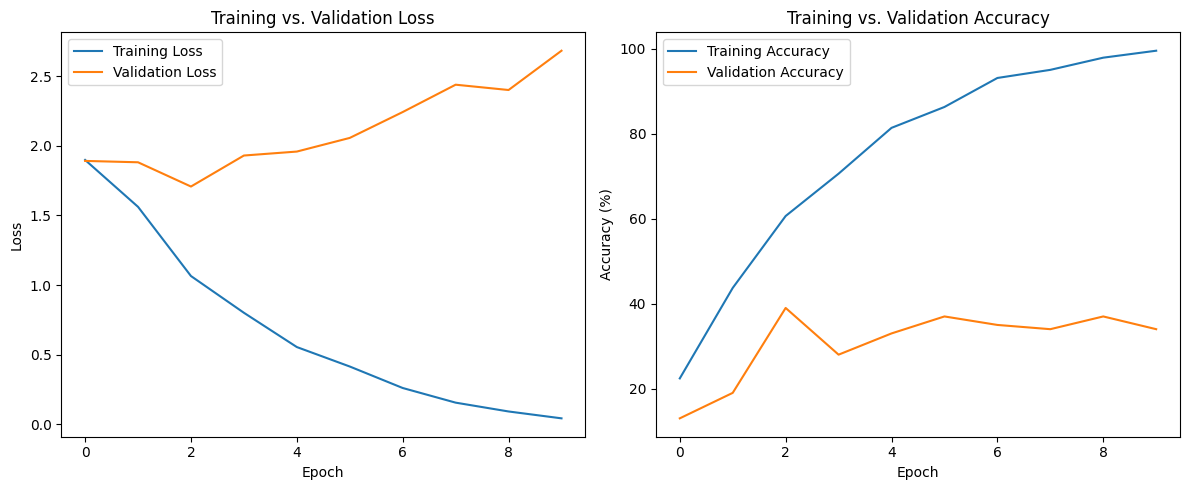

In [29]:
train_losses, train_accuracies, validation_losses, validation_accuracies = (
    train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, 10, device
    )
)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)